In [11]:
import os
import io
import math
import time
import ssl
import certifi
import urllib3
import itertools
from collections import Counter
from statistics import correlation
from importlib import import_module
from io import BytesIO

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm
import seaborn as sns

# Statistics & Math
from scipy.stats import t, norm
from scipy.stats.mstats import winsorize

# Machine Learning
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import GradientBoostingRegressor

# Time Series
from pandas.tseries.offsets import DateOffset

# File Handling & Parquet
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds

# APIs & Data Sources
import requests
import wrds
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random

In [2]:
folder = os.path.expanduser('~/Desktop/Machine Learning/data_ML_Project')
folder1 = os.path.expanduser('~/Desktop/Machine Learning/data_filtered')

# CSV Files
main_csv = os.path.join(folder, 'monthly_crsp.csv')
jkp_csv = os.path.join(folder1, 'JKP_filtered.csv')
zimmer_csv = os.path.join(folder1, 'Zimmer_filtered.csv')


if os.path.exists(folder):
    data_main = pd.read_csv(main_csv)
    data_jkp = pd.read_csv(jkp_csv)
    data_zimmer = pd.read_csv(zimmer_csv)
    
else:
    print("File still not found!")


In [3]:
data_main.head()

,PERMNO,HdrCUSIP,CUSIP,Ticker,TradingSymbol,PERMCO,SICCD,NAICS,MthCalDt,MthRet,sprtrn
0,10000,68391610,68391610,OMFGA,OMFGA,7952,3990,0,1986-01-31,0.707317,0.002367
1,10000,68391610,68391610,OMFGA,OMFGA,7952,3990,0,1986-02-28,-0.257143,0.071489
2,10000,68391610,68391610,OMFGA,OMFGA,7952,3990,0,1986-03-31,0.365385,0.052794
3,10000,68391610,68391610,OMFGA,OMFGA,7952,3990,0,1986-04-30,-0.098592,-0.014148
4,10000,68391610,68391610,OMFGA,OMFGA,7952,3990,0,1986-05-30,-0.222656,0.050229


In [4]:
# Ensure 'date' is in datetime format
data_main['date'] = pd.to_datetime(data_main['MthCalDt'])
data_jkp['date'] = pd.to_datetime(data_jkp['date'])
data_zimmer['date'] = pd.to_datetime(data_zimmer['date'], errors='coerce')

# Filter from 1986 onwards
start_date = pd.to_datetime('1986-01-01')
data_main = data_main[data_main['date'] >= start_date]
data_jkp = data_jkp[data_jkp['date'] >= start_date]
data_zimmer = data_zimmer[data_zimmer['date'] >= start_date]

# Create 'year' and 'month' columns for merging
for df in [data_main, data_jkp, data_zimmer]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

# Merge first with data_jkp
merged = data_main.merge(
    data_jkp.drop(columns=['date']),
    on=['year', 'month'],
    how='left',
    suffixes=('', '_jkp')
)

# Merge next with data_zimmer
merged = merged.merge(
    data_zimmer.drop(columns=['date']),
    on=['year', 'month'],
    how='left',
    suffixes=('', '_zimmer')
)


In [5]:
# Keep only tickers with at least 300 records
merged = merged[merged.groupby('Ticker')['Ticker'].transform('count') >= 300]


In [6]:
print("String columns:", merged.select_dtypes(include=["object", "string"]).columns.tolist())

String columns: ['HdrCUSIP', 'CUSIP', 'Ticker', 'TradingSymbol', 'MthCalDt']


In [7]:
columns_to_drop = [ 
    'PERMNO', 'HdrCUSIP', 'CUSIP', 'TradingSymbol', 'PERMCO', 'SICCD', 'NAICS','date','year','month'
]

merged.drop(columns=columns_to_drop, inplace=True)

In [8]:
# Shift 'MthRet' and 'sprtrn' within each Ticker group
merged[['MthRet', 'sprtrn']] = merged.groupby('Ticker')[['MthRet', 'sprtrn']].shift(1).fillna(0)



In [9]:
merged.head()

,Ticker,MthCalDt,MthRet,sprtrn,age,aliq_at,aliq_mat,ami_126d,at_be,at_gr1,...,TotalAccruals,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,zerotrade,zerotradeAlt1,zerotradeAlt12
1864,CCUR,1986-01-31,0.000000,0.000000,0.006711,0.004169,-0.018659,-0.000338,-0.017403,-0.009232,...,1.857711,-0.272865,-2.906878,-0.447387,-2.097407,2.251081,-4.300391,-1.707059,-2.762641,-0.953306
1865,CCUR,1986-02-28,-0.034286,0.002367,-0.018169,-0.019808,0.001281,-0.019824,-0.016957,-0.017365,...,0.337758,1.633203,-0.183636,-1.530948,-0.314238,-2.494758,-1.362646,-0.992299,-3.608234,-2.118101
1866,CCUR,1986-03-31,0.065089,0.071489,-0.012611,-0.016977,-0.000853,-0.004353,-0.005036,-0.013166,...,-0.965395,-0.853914,-0.819430,2.812237,1.940383,-0.161159,2.169318,2.620464,-1.279099,2.060085
1867,CCUR,1986-04-30,-0.177778,0.052794,0.044027,-0.030128,0.037628,0.034508,0.029370,-0.011328,...,-1.418417,0.443374,-0.653648,1.018628,3.189093,-0.258417,-1.467254,2.959722,0.607949,2.217132
1868,CCUR,1986-05-30,-0.108108,-0.014148,-0.003599,-0.012475,0.014284,-0.011692,-0.001139,-0.005564,...,1.420998,1.197268,-0.156654,1.224972,-1.771923,0.011794,0.329157,-2.822498,-3.842631,-2.194208


In [101]:
tickers = merged['Ticker'].unique()
random_ticker = random.choice(tickers)
print(f"Randomly selected ticker: {random_ticker}")

Randomly selected ticker: AAP


In [102]:
ticker_data = merged[merged['Ticker'] == random_ticker].copy()

X = ticker_data.drop(columns=['MthCalDt', 'sprtrn', 'Ticker', 'MthRet'])

# Target is MthRet
y = ticker_data['MthRet']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (284, 355)
X_test shape: (71, 355)
y_train shape: (284,)
y_test shape: (71,)


In [103]:
# Find columns that are not numeric
non_numeric_cols = X_train.select_dtypes(exclude=[float, int]).columns.tolist()

print("Non-numeric columns causing the problem:", non_numeric_cols)


Non-numeric columns causing the problem: []


In [104]:
# Convert to NumPy array first
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


In [105]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [106]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [107]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [108]:
class FlexibleMLP(nn.Module):
    def __init__(self, layers: list, scale: float = 1.0, bias_scale: float = 0.0, activation=nn.GELU()):
        """
        Initialize a customizable Multi-Layer Perceptron (MLP) with flexible architecture and initialization.

        Args:
            layers (list of int): A list of integers where each value defines the size of each layer.
                                  For example, layers=[10, 64, 32, 1] defines a network with input dimension 10,
                                  two hidden layers with sizes 64 and 32, and output dimension 1.
            scale (float): Scaling factor for weight initialization. Controls the standard deviation of
                           the normal distribution used in initializing weights. Recommended to be 1.0 for LeCun initialization.
            bias_scale (float): Scaling factor for bias initialization. Often set to 0.0 to start with no initial bias.
            activation (nn.Module): Activation function applied after each linear transformation except the last layer.
                                    Defaults to nn.GELU(), but can be any activation like nn.ReLU(), nn.Tanh(), etc.
        """
        # Call the constructor of the parent class (nn.Module) to initialize all internal PyTorch machinery.
        # This is crucial because nn.Module handles a lot of behind-the-scenes logic like:
        # - registering parameters (weights and biases) for automatic optimization
        # - setting up .to(device), .eval(), .train(), etc.
        # - tracking submodules (layers, activations, etc.)
        #
        # If you omit this line, the module will NOT work correctly in PyTorch:
        # things like model.cuda(), model.parameters(), model.state_dict(), etc. will all break.
        #
        # The super() call here:
        # - FlexibleMLP is our class
        # - nn.Module is the parent class
        # - self.__init__() is the method we want to call from the parent
        super(FlexibleMLP, self).__init__()

        # Save arguments as attributes for reuse in reset_parameters
        self.layer_sizes = layers
        self.scale = scale
        self.bias_scale = bias_scale
        self.activation_fn = activation

        # Create containers to hold layers and activations
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        # Build network structure (but not weights yet)
        self._build_layers()

        # Initialize weights and biases
        self.reset_parameters()

    def _build_layers(self):
        """
        Build the linear layers and corresponding activations (except for initialization).
        """
        for i in range(len(self.layer_sizes) - 1):
            # Create a linear layer from layer i to layer i+1
            layer = nn.Linear(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.layers.append(layer)

            # Add an activation function unless it's the final layer
            if i < len(self.layer_sizes) - 2:
                self.activations.append(self.activation_fn)
            else:
                # Final layer doesn't use activation (use Identity to keep list structure consistent)
                self.activations.append(nn.Identity())

    def reset_parameters(self):
        """
        Apply custom initialization to all layers using the given scale and bias_scale.
        """
        for i, layer in enumerate(self.layers):
            # Apply LeCun-style initialization for better gradient behavior
            nn.init.normal_(layer.weight, mean=0.0, std=self.scale * np.sqrt(1 / self.layer_sizes[i]))
            nn.init.normal_(layer.bias, mean=0.0, std=self.bias_scale * np.sqrt(1 / self.layer_sizes[i]))

    def forward(self, x, return_last_hidden=False):
        """
        Perform a forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
            return_last_hidden (bool): If True, returns both the final output and the last hidden layer's output.
                                       Useful for feature extraction, analysis, or interpretability.

        Returns:
            torch.Tensor: Output of the final layer.
            torch.Tensor (optional): Output of the last hidden layer (before final linear layer),
                                     if return_last_hidden is set to True.
        """
        last_hidden = None  # Will store the output of the last hidden layer

        # Apply all but the last layer with activation
        for layer, activation in zip(self.layers[:-1], self.activations[:-1]):
            x = activation(layer(x))  # Apply linear transformation and activation
            last_hidden = x  # Save the last hidden output

        # Final layer (linear transformation only, no activation)
        x = self.layers[-1](x)

        if return_last_hidden:
            return x, last_hidden
        return x

In [109]:
def set_seed(seed_value=42):
    """
    Set random seed across NumPy, Python, and PyTorch to ensure reproducibility.

    Args:
        seed_value (int): The seed value to use. Default is 42, a commonly used arbitrary number.

    This function ensures that experiments produce the same results across different runs,
    which is critical for debugging, comparing models, and scientific reproducibility.

    It sets the seed for:
        - NumPy (used for numerical ops like matrix generation)
        - Python's built-in random module (used in random sampling, shuffling, etc.)
        - PyTorch (both CPU and GPU)

    For GPU reproducibility:
        - It manually sets the CUDA seeds (for single and multi-GPU setups)
        - It disables the CUDA backend benchmarking feature to ensure deterministic behavior
          (at the potential cost of performance).
    """

    # Set seed for NumPy (used in data shuffling, batch generation, etc.)
    np.random.seed(seed_value)

    # Set seed for PyTorch operations on CPU
    torch.manual_seed(seed_value)

    # Set seed for Python's built-in random module (e.g., random.shuffle, random.randint)
    random.seed(seed_value)

    # Set seeds for PyTorch operations on GPU
    if torch.cuda.is_available():
        # Set seed for single-GPU
        torch.cuda.manual_seed(seed_value)

        # Set seed for all available GPUs (multi-GPU training)
        torch.cuda.manual_seed_all(seed_value)

        # Ensures that CUDA uses deterministic algorithms
        # This disables non-deterministic optimizations and ensures reproducible behavior
        torch.backends.cudnn.deterministic = True

        # Disables cuDNN auto-tuner which selects the best algorithm for each configuration
        # When disabled, it uses deterministic algorithms, but this might make training slower
        torch.backends.cudnn.benchmark = False

# Set the seed globally so every run starts from the same state
set_seed(42)


In [110]:
def train_model(num_epochs: int,
                train_loader: torch.utils.data.DataLoader,
                criterion,
                optimizer,
                model: torch.nn.Module,
                ridge_penalty: float = 0.001):
    """
    Train a PyTorch model using mini-batch gradient descent with optional L2 (ridge) regularization.

    Args:
        num_epochs (int): Number of full passes through the training dataset.
        train_loader (DataLoader): PyTorch DataLoader containing training data in mini-batches.
        criterion: Loss function (e.g., nn.MSELoss).
        optimizer: PyTorch optimizer (e.g., torch.optim.Adam or SGD).
        model (nn.Module): The model to train.
        ridge_penalty (float): L2 regularization strength (default: 0.001). Helps reduce overfitting.

    Returns:
        None. Prints training loss every 20 epochs.
    """
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            # Forward pass: get model predictions for this batch
            outputs = model(inputs)

            # Compute loss = prediction error + ridge penalty (L2 regularization)
            # The penalty term prevents overfitting by discouraging large weights
            # sum(p.abs().pow(2).sum()) is equivalent to ||W||² (squared L2 norm)
            loss = criterion(outputs, targets) + ridge_penalty * sum(p.pow(2.0).sum() for p in model.parameters())

            # Backward pass and optimization:
            optimizer.zero_grad()   # Clear previous gradients to prevent accumulation
            loss.backward()         # Backpropagate the current loss
            optimizer.step()        # Perform a parameter update (gradient descent step)

        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


In [111]:
# Initialize the deep neural network model
num_seeds = 10 # 10 !!
ridge_penalty = 0# 0.01 ?

set_seed(42)
width = 500# 256 # also try 100
model_architecture = [X_train.shape[1], width, width, 1]
models = [FlexibleMLP(model_architecture) for seed in range(num_seeds)]

# Proceed with the rest of the setup (loss, optimizer) and training loop as before
# Loss and optimizer
for seed in range(num_seeds):

  set_seed(seed)
  criterion = nn.MSELoss()
  # do not forget to experiment with both SGD and Adam
  #optimizer = optim.Adam(models[seed].parameters(), lr=0.1) #, weight_decay=0)
  # Using Adam optimizer for better performance with deep networks. large learning rate leads to some interesting catapult behavior!
  optimizer = optim.SGD(models[seed].parameters(), lr=0.0001)

  train_model(num_epochs=400, # try also 200, 400 could be slow, but we do need more epochs to achieve interpolation
              train_loader=train_loader,
              criterion=criterion,
              optimizer=optimizer,
              model=models[seed],
              ridge_penalty=ridge_penalty)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [20/400], Loss: 0.1637
Epoch [40/400], Loss: 0.2127
Epoch [60/400], Loss: 0.1768
Epoch [80/400], Loss: 0.1283
Epoch [100/400], Loss: 0.0765
Epoch [120/400], Loss: 0.1066
Epoch [140/400], Loss: 0.0862
Epoch [160/400], Loss: 0.0661
Epoch [180/400], Loss: 0.0255
Epoch [200/400], Loss: 0.0333
Epoch [220/400], Loss: 0.0307
Epoch [240/400], Loss: 0.0282
Epoch [260/400], Loss: 0.0267
Epoch [280/400], Loss: 0.0232
Epoch [300/400], Loss: 0.0178
Epoch [320/400], Loss: 0.0348
Epoch [340/400], Loss: 0.0247
Epoch [360/400], Loss: 0.0283
Epoch [380/400], Loss: 0.0201
Epoch [400/400], Loss: 0.0108
Epoch [20/400], Loss: 0.2897
Epoch [40/400], Loss: 0.1329
Epoch [60/400], Loss: 0.1266
Epoch [80/400], Loss: 0.0873
Epoch [100/400], Loss: 0.0671
Epoch [120/400], Loss: 0.0731
Epoch [140/400], Loss: 0.0699
Epoch [160/400], Loss: 0.0391
Epoch [180/400], Loss: 0.0415
Epoch [200/400], Loss: 0.0294
Epoch [220/400], Loss: 0.0344
Epoch [240/400], Loss: 0.0447
Epoch [260/400], Loss: 0.0531
Epoch [280/400], L

In [112]:
# Ensure the model is in evaluation mode
# Function to get predictions
def get_predictions(loader, model):
    model.eval()
    targets = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            targets.extend(labels.numpy())
            predictions.extend(outputs.numpy())

    return np.array(targets).flatten(), np.array(predictions).flatten()

# Get predictions for both training and test sets
train_sample = [get_predictions(train_loader, models[seed]) for seed in range(num_seeds)]
test_sample = [get_predictions(test_loader, models[seed]) for seed in range(num_seeds)]
train_targets = train_sample[0][0]
# here, I am taking a mean over the 10 random seeds
train_predictions = np.concatenate([train_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1)


In [113]:
# prompt: concatenate train predictions and train targets, make a dataframe
# Assuming train_targets and train_predictions are already defined as in the provided code

train_df = pd.DataFrame({'targets': train_targets, **{f'prediction_{i}': train_predictions[:, i] for i in range(train_predictions.shape[1])}})
print(train_df.head(10))
train_predictions = train_predictions.mean(1)

    targets  prediction_0  prediction_1  prediction_2  prediction_3  \
0  0.008468     -0.096700     -0.054154     -0.106077      0.053133   
1  0.026453      0.010977     -0.120375     -0.105978     -0.102689   
2 -0.050912      0.044427      0.068935      0.258353     -0.039942   
3  0.039594      0.051420     -0.032393     -0.201693     -0.069283   
4  0.068742      0.248068      0.115532      0.103908      0.010195   
5  0.305389      0.053787      0.048070      0.009792      0.012334   
6 -0.052096     -0.168533     -0.023846     -0.080569      0.105084   
7 -0.188463      0.120499     -0.015206     -0.134917      0.184584   
8 -0.119241      0.064425     -0.066530     -0.183054     -0.134537   
9 -0.114183      0.124346     -0.118952      0.095849     -0.001814   

   prediction_4  prediction_5  prediction_6  prediction_7  prediction_8  \
0      0.111297      0.072136      0.245238      0.002440      0.009038   
1     -0.058993      0.090229      0.039420      0.139864     -0.065

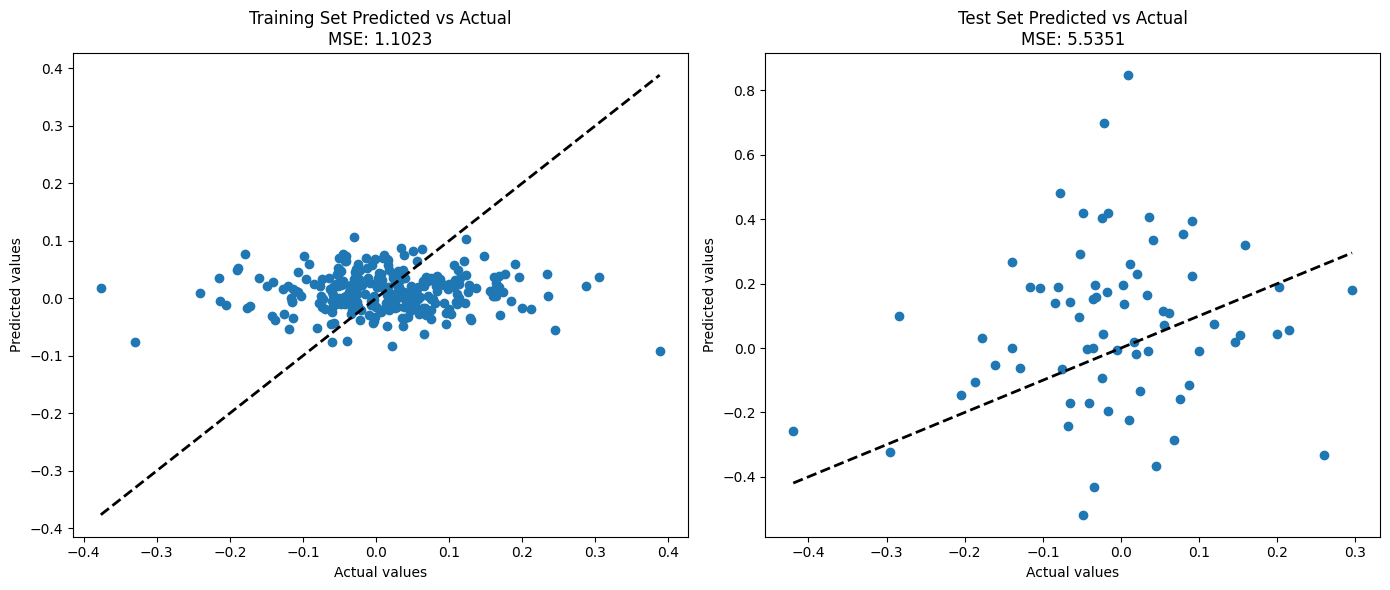

In [114]:
test_targets = test_sample[0][0]
all_test_predictions = np.concatenate([test_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1)

# here, I am taking a mean over the 10 random seeds
test_predictions = all_test_predictions.mean(1)

# Calculate MSE for both training and test sets
train_mse = np.mean((train_targets - train_predictions) ** 2) / np.mean(train_targets ** 2)
test_mse = np.mean((test_targets.reshape(-1, 1) - test_predictions) ** 2) / np.mean(test_targets ** 2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Training set subplot
axs[0].scatter(train_targets, train_predictions)
axs[0].plot([train_targets.min(), train_targets.max()], [train_targets.min(), train_targets.max()], 'k--', lw=2)  # Diagonal line
axs[0].set_xlabel('Actual values')
axs[0].set_ylabel('Predicted values')
axs[0].set_title(f'Training Set Predicted vs Actual\nMSE: {train_mse:.4f}')

# Test set subplot
axs[1].scatter(test_targets, test_predictions)#.mean(1))
axs[1].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'k--', lw=2)  # Diagonal line
axs[1].set_xlabel('Actual values')
axs[1].set_ylabel('Predicted values')
axs[1].set_title(f'Test Set Predicted vs Actual\nMSE: {test_mse:.4f}')

plt.tight_layout()
plt.show()


/var/folders/rj/fv3npnl910bd6btffd6d3ph80000gn/T/ipykernel_88037/3603607014.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_dates = pd.date_range(start='2000-01-01', periods=len(y_train), freq='M')


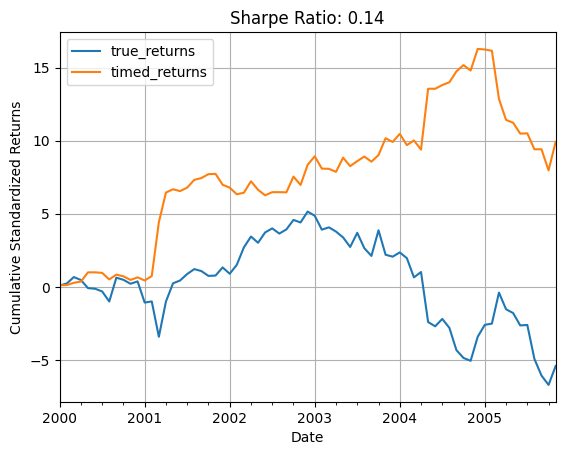

In [115]:
# If train_targets and train_predictions are already NumPy arrays, just reshape
y_train = test_targets.reshape(-1, 1)
y_pred_train = test_predictions.reshape(-1, 1)

# Multiply true returns by model's predictions
timed_returns = y_train * y_pred_train

# Create dummy train_dates if needed
train_dates = pd.date_range(start='2000-01-01', periods=len(y_train), freq='M')

# Build DataFrame
together = pd.DataFrame(
    np.concatenate([y_train, timed_returns], axis=1),
    columns=['true_returns', 'timed_returns'],
    index=train_dates
)

# Standardize and plot cumulative sum
(together / together.std()).cumsum().plot()
plt.title(f'Sharpe Ratio: {together['timed_returns'].mean() / together['timed_returns'].std():.2f}')
plt.xlabel("Date")
plt.ylabel("Cumulative Standardized Returns")
plt.grid(True)
plt.show()
